In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 256)        1024      
_________________________________________________________________
activation (Activation)      (None, 16000, 256)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4096000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 256)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 256)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9937 - acc: 0.3809
Epoch 00001: val_loss improved from inf to 1.13620, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_6_conv_checkpoint/001-1.1362.hdf5
36805/36805 [==============================] - 388s 11ms/sample - loss: 1.9937 - acc: 0.3810 - val_loss: 1.1362 - val_acc: 0.6546
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1975 - acc: 0.6233
Epoch 00002: val_loss improved from 1.13620 to 0.83174, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_6_conv_checkpoint/002-0.8317.hdf5
36805/36805 [==============================] - 382s 10ms/sample - loss: 1.1976 - acc: 0.6233 - val_loss: 0.8317 - val_acc: 0.7566
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9447 - acc: 0.7074
Epoch 00003: val_loss improved from 0.83174 to 0.82742, saving model 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2236 - acc: 0.9285
Epoch 00024: val_loss did not improve from 0.34806
36805/36805 [==============================] - 382s 10ms/sample - loss: 0.2237 - acc: 0.9285 - val_loss: 0.3509 - val_acc: 0.9059
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9326
Epoch 00025: val_loss did not improve from 0.34806
36805/36805 [==============================] - 383s 10ms/sample - loss: 0.2152 - acc: 0.9326 - val_loss: 0.3861 - val_acc: 0.8949
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2069 - acc: 0.9344
Epoch 00026: val_loss did not improve from 0.34806
36805/36805 [==============================] - 381s 10ms/sample - loss: 0.2070 - acc: 0.9343 - val_loss: 0.3797 - val_acc: 0.9036
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1990 - acc: 0.9376
Epoch 00027: val_loss did not improve from 0.34806
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9732
Epoch 00052: val_loss did not improve from 0.32563
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0834 - acc: 0.9732 - val_loss: 0.4231 - val_acc: 0.9026
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9717
Epoch 00053: val_loss did not improve from 0.32563
36805/36805 [==============================] - 381s 10ms/sample - loss: 0.0876 - acc: 0.9717 - val_loss: 0.3598 - val_acc: 0.9210
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9745
Epoch 00054: val_loss did not improve from 0.32563
36805/36805 [==============================] - 383s 10ms/sample - loss: 0.0812 - acc: 0.9745 - val_loss: 0.3397 - val_acc: 0.9185
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0783 - acc: 0.9749
Epoch 00055: val_loss did not improve from 0.32563
36805/36805 [==================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9880
Epoch 00082: val_loss did not improve from 0.32563
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0393 - acc: 0.9880 - val_loss: 0.4209 - val_acc: 0.9078
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9868
Epoch 00083: val_loss did not improve from 0.32563
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0431 - acc: 0.9868 - val_loss: 0.3819 - val_acc: 0.9210
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9863
Epoch 00084: val_loss did not improve from 0.32563
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0424 - acc: 0.9863 - val_loss: 0.3841 - val_acc: 0.9178
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9855
Epoch 00085: val_loss did not improve from 0.32563
36805/36805 [=====

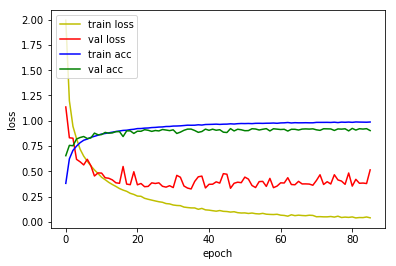

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.3842 - acc: 0.8964
Loss: 0.38417450881573767 Accuracy: 0.8963655

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1621 - acc: 0.3387
Epoch 00001: val_loss improved from inf to 1.16462, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_7_conv_checkpoint/001-1.1646.hdf5
36805/36805 [==============================] - 384s 10ms/sample - loss: 2.1621 - acc: 0.3386 - val_loss: 1.1646 - val_acc: 0.6550
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2783 - acc: 0.5906
Epoch 00002: val_loss improved from 1.16462 to 0.85832, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_7_conv_checkpoint/002-0.8583.hdf5
36805/36805 [==============================] - 379s 10ms/sample - loss: 1.2784 - acc: 0.5906 - val_loss: 0.8583 - val_acc: 0.7503
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1510 - acc: 0.9531
Epoch 00025: val_loss did not improve from 0.21843
36805/36805 [==============================] - 380s 10ms/sample - loss: 0.1511 - acc: 0.9531 - val_loss: 0.2589 - val_acc: 0.9304
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1552 - acc: 0.9504
Epoch 00026: val_loss improved from 0.21843 to 0.19271, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_7_conv_checkpoint/026-0.1927.hdf5
36805/36805 [==============================] - 379s 10ms/sample - loss: 0.1553 - acc: 0.9504 - val_loss: 0.1927 - val_acc: 0.9511
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1427 - acc: 0.9559
Epoch 00027: val_loss did not improve from 0.19271
36805/36805 [==============================] - 379s 10ms/sample - loss: 0.1428 - acc: 0.9559 - val_loss: 0.2194 - val_acc: 0.9448
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9787
Epoch 00054: val_loss did not improve from 0.19181
36805/36805 [==============================] - 379s 10ms/sample - loss: 0.0668 - acc: 0.9786 - val_loss: 0.1956 - val_acc: 0.9539
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.9842
Epoch 00055: val_loss did not improve from 0.19181
36805/36805 [==============================] - 380s 10ms/sample - loss: 0.0511 - acc: 0.9842 - val_loss: 0.2192 - val_acc: 0.9471
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9864
Epoch 00056: val_loss did not improve from 0.19181
36805/36805 [==============================] - 379s 10ms/sample - loss: 0.0455 - acc: 0.9864 - val_loss: 0.2099 - val_acc: 0.9550
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9834
Epoch 00057: val_loss did not improve from 0.19181
36805/36805 [=====

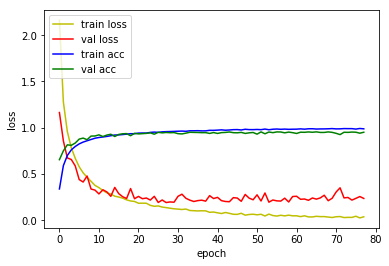

4815/4815 [==============================] - 22s 5ms/sample - loss: 0.2345 - acc: 0.9346
Loss: 0.23450478180732312 Accuracy: 0.93457943

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1306 - acc: 0.3609
Epoch 00001: val_loss improved from inf to 1.02030, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_8_conv_checkpoint/001-1.0203.hdf5
36805/36805 [==============================] - 391s 11ms/sample - loss: 2.1306 - acc: 0.3609 - val_loss: 1.0203 - val_acc: 0.6983
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1843 - acc: 0.6248
Epoch 00002: val_loss improved from 1.02030 to 0.64566, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_8_conv_checkpoint/002-0.6457.hdf5
36805/36805 [==============================] - 387s 11ms/sample - loss: 1.1843 - acc: 0.6248 - val_loss: 0.6457 - val_acc: 0.8160
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9684
Epoch 00026: val_loss did not improve from 0.12618
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0994 - acc: 0.9684 - val_loss: 0.1382 - val_acc: 0.9625
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9710
Epoch 00027: val_loss did not improve from 0.12618
36805/36805 [==============================] - 381s 10ms/sample - loss: 0.0891 - acc: 0.9710 - val_loss: 0.1494 - val_acc: 0.9613
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9745
Epoch 00028: val_loss did not improve from 0.12618
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0820 - acc: 0.9745 - val_loss: 0.1316 - val_acc: 0.9655
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0800 - acc: 0.9745
Epoch 00029: val_loss did not improve from 0.12618
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9928
Epoch 00055: val_loss did not improve from 0.12434
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0252 - acc: 0.9928 - val_loss: 0.1392 - val_acc: 0.9660
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9922
Epoch 00056: val_loss did not improve from 0.12434
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0256 - acc: 0.9921 - val_loss: 0.1477 - val_acc: 0.9623
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9883
Epoch 00057: val_loss did not improve from 0.12434
36805/36805 [==============================] - 383s 10ms/sample - loss: 0.0397 - acc: 0.9883 - val_loss: 0.1395 - val_acc: 0.9653
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9890
Epoch 00058: val_loss did not improve from 0.12434
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9962
Epoch 00084: val_loss did not improve from 0.12034
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0130 - acc: 0.9962 - val_loss: 0.1366 - val_acc: 0.9693
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9967
Epoch 00085: val_loss did not improve from 0.12034
36805/36805 [==============================] - 381s 10ms/sample - loss: 0.0118 - acc: 0.9967 - val_loss: 0.1445 - val_acc: 0.9697
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9968
Epoch 00086: val_loss did not improve from 0.12034
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0125 - acc: 0.9968 - val_loss: 0.1559 - val_acc: 0.9679
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9941
Epoch 00087: val_loss did not improve from 0.12034
36805/36805 [==================

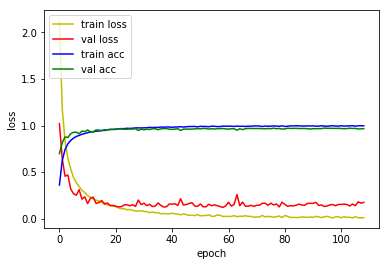

4815/4815 [==============================] - 23s 5ms/sample - loss: 0.1596 - acc: 0.9605
Loss: 0.15961949999133745 Accuracy: 0.96054

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0675 - acc: 0.3835
Epoch 00001: val_loss improved from inf to 0.86604, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_9_conv_checkpoint/001-0.8660.hdf5
36805/36805 [==============================] - 394s 11ms/sample - loss: 2.0674 - acc: 0.3835 - val_loss: 0.8660 - val_acc: 0.7531
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0545 - acc: 0.6713
Epoch 00002: val_loss improved from 0.86604 to 0.59124, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_9_conv_checkpoint/002-0.5912.hdf5
36805/36805 [==============================] - 389s 11ms/sample - loss: 1.0548 - acc: 0.6712 - val_loss: 0.5912 - val_acc: 0.8472
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.75

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9695
Epoch 00026: val_loss improved from 0.11660 to 0.11602, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_9_conv_checkpoint/026-0.1160.hdf5
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.1047 - acc: 0.9694 - val_loss: 0.1160 - val_acc: 0.9653
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0988 - acc: 0.9711
Epoch 00027: val_loss improved from 0.11602 to 0.10906, saving model to model/checkpoint/1D_CNN_custom_2_DO_BN_9_conv_checkpoint/027-0.1091.hdf5
36805/36805 [==============================] - 385s 10ms/sample - loss: 0.0988 - acc: 0.9710 - val_loss: 0.1091 - val_acc: 0.9669
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9717
Epoch 00028: val_loss did not improve from 0.10906
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0933 - acc: 0.9717 - val_loss: 0.1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9897
Epoch 00054: val_loss did not improve from 0.08783
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0353 - acc: 0.9897 - val_loss: 0.1044 - val_acc: 0.9723
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9905
Epoch 00055: val_loss did not improve from 0.08783
36805/36805 [==============================] - 385s 10ms/sample - loss: 0.0334 - acc: 0.9904 - val_loss: 0.1115 - val_acc: 0.9700
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9879
Epoch 00056: val_loss did not improve from 0.08783
36805/36805 [==============================] - 389s 11ms/sample - loss: 0.0406 - acc: 0.9879 - val_loss: 0.1058 - val_acc: 0.9711
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9893
Epoch 00057: val_loss did not improve from 0.08783
36805/36805 [==================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9954
Epoch 00084: val_loss did not improve from 0.08783
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0174 - acc: 0.9954 - val_loss: 0.1142 - val_acc: 0.9709
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9938
Epoch 00085: val_loss did not improve from 0.08783
36805/36805 [==============================] - 386s 10ms/sample - loss: 0.0212 - acc: 0.9938 - val_loss: 0.1176 - val_acc: 0.9681
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9948
Epoch 00086: val_loss did not improve from 0.08783
36805/36805 [==============================] - 389s 11ms/sample - loss: 0.0183 - acc: 0.9948 - val_loss: 0.1331 - val_acc: 0.9704
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9942
Epoch 00087: val_loss did not improve from 0.08783
36805/36805 [=====

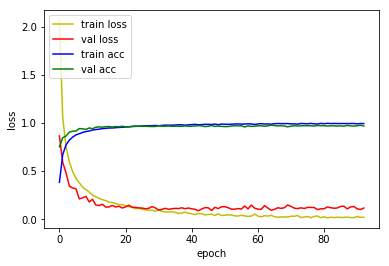

4815/4815 [==============================] - 23s 5ms/sample - loss: 0.1256 - acc: 0.9628
Loss: 0.12563233519551323 Accuracy: 0.9628245



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_45_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1369616     lambda[0][0]                     
                                                                 lambda_1

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_DO_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_45_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1369616     lambda[0][0]                     
                                                                 lambda_1